In [1]:
import pickle
import matplotlib.pyplot as plt
import adaptive_latents as al
import glob
import subprocess
import numpy as np

In [2]:
# run the same script, using cpu and gpu
# subprocess.call(["python", "run_example.py", "gpu"])
# subprocess.call(["python", "run_example.py", "cpu"])
# backends = ["gpu", "cpu"]

In [3]:
# extract the two most recent bubblewrap runs
files = sorted(glob.glob(f"{al.CONFIG["output_path"]/"bubblewrap_runs"}/*.pickle"))
brs = []
for file in files[-2:]:
    with open(file, 'br') as fhan:
        brs.append(pickle.load(fhan))

/home/jgould/Documents/AdaptiveLatents/adaptive_latents/plotting_functions.py:480: UserWarning: check these timepoints actually line up, I'm just clipping here
  warnings.warn("check these timepoints actually line up, I'm just clipping here")


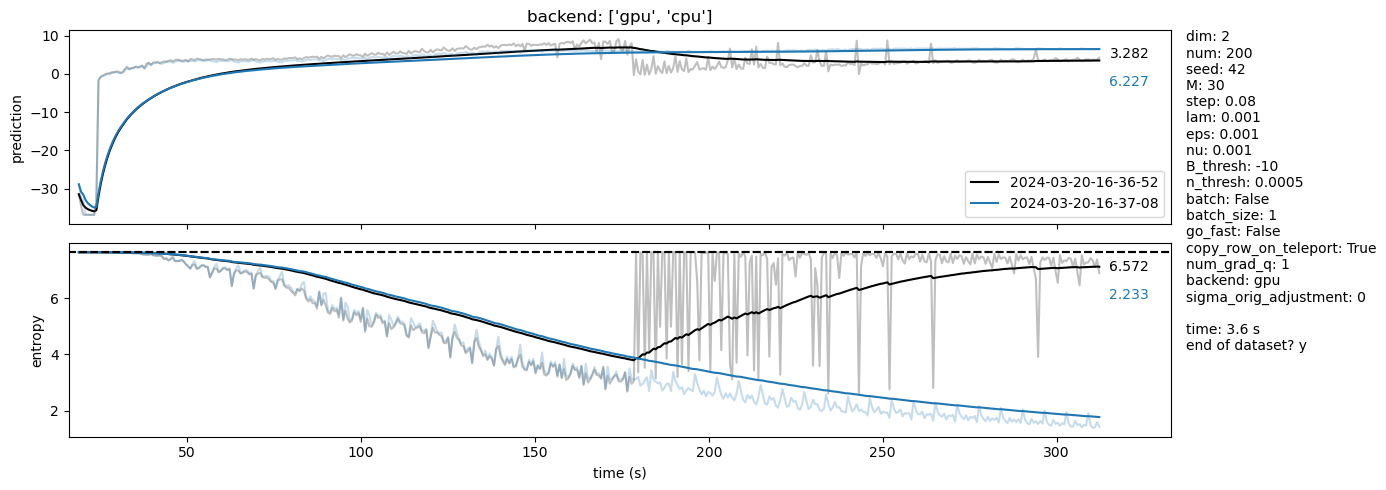

In [4]:
# establish there's still a divergence
%matplotlib inline
al.plotting_functions.compare_metrics(brs, 1)

## alpha

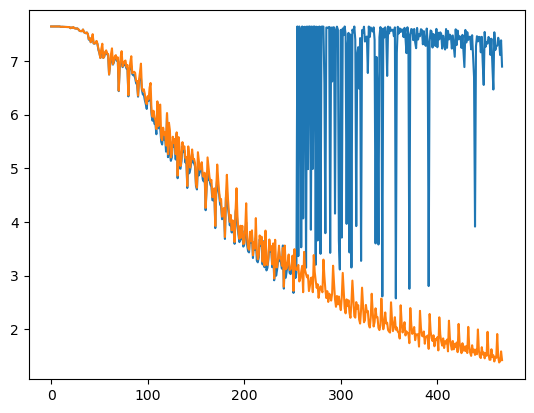

In [5]:
# show the entropy divergence can be reconstructed offline
%matplotlib inline
entropies = []

for br in brs:
    entropies.append([])
    for i in np.arange(br.alpha_history[1].shape[0]):
        p = br.alpha_history[0][i] @ br.A_history[i]
        entropies[-1].append(-(p @ np.log2(p)).mean())
entropies = np.array(entropies)
plt.plot(entropies.T)

first_divergence_index = np.nonzero(np.abs(np.diff(entropies, axis=0)) > 1)[1][0]

## B and pre_B

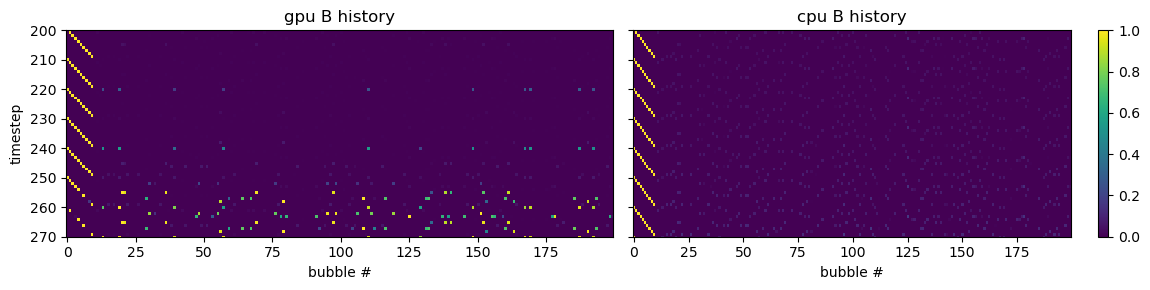

In [6]:
# show how B is different in the cpu vs gpu runs 
%matplotlib inline
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,3), layout='tight');
ax[0].imshow(brs[0].B_history, interpolation='none', aspect='auto', vmin=0, vmax=1);
img = ax[1].imshow(brs[1].B_history, interpolation='none', aspect='auto', vmin=0, vmax=1);
fig.colorbar(img)

ax[0].set_ylabel("timestep");
ax[0].set_xlabel("bubble #");
ax[1].set_xlabel("bubble #");

ax[0].set_title("gpu B history");
ax[1].set_title("cpu B history");


ax[0].set_ylim([270,200]);

Text(0.5, 1.0, 'GPU pre_B')

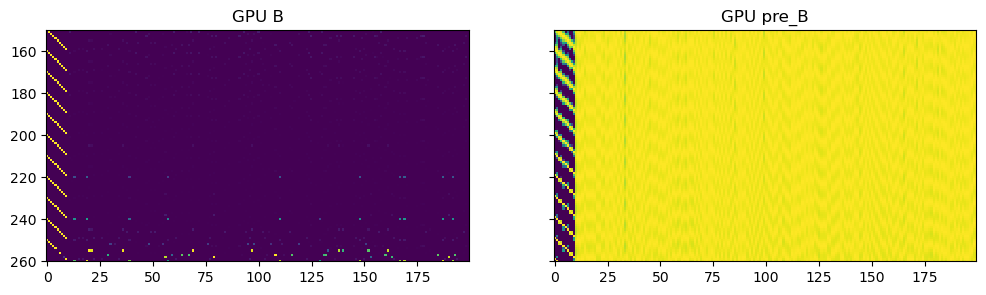

In [7]:
# compare the pre-exp B to real B on the GPU
%matplotlib inline
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,3));
ax[0].imshow(brs[0].B_history, interpolation='none', aspect='auto');
ax[1].imshow(brs[0].pre_B_history, interpolation='none', aspect='auto', vmin = -12.5e3);
ax[0].set_ylim([260,150]);
ax[0].set_title("GPU B")
ax[1].set_title("GPU pre_B")

Note that you can manually suppress B elements beyond 10 but it doesn't help.

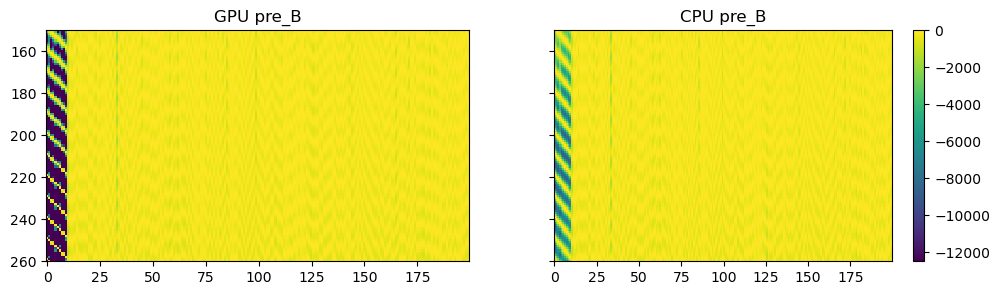

In [8]:
# compare pre_B on gpu and cpu
%matplotlib inline
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,3));
img = ax[0].imshow(brs[0].pre_B_history, interpolation='none', aspect='auto', vmin = -12.5e3);
img = ax[1].imshow(brs[1].pre_B_history, interpolation='none', aspect='auto', vmin = -12.5e3);
fig.colorbar(img);
ax[0].set_ylim([260,150]);
ax[0].set_title("GPU pre_B")
ax[1].set_title("CPU pre_B");

NameError: name 'backends' is not defined

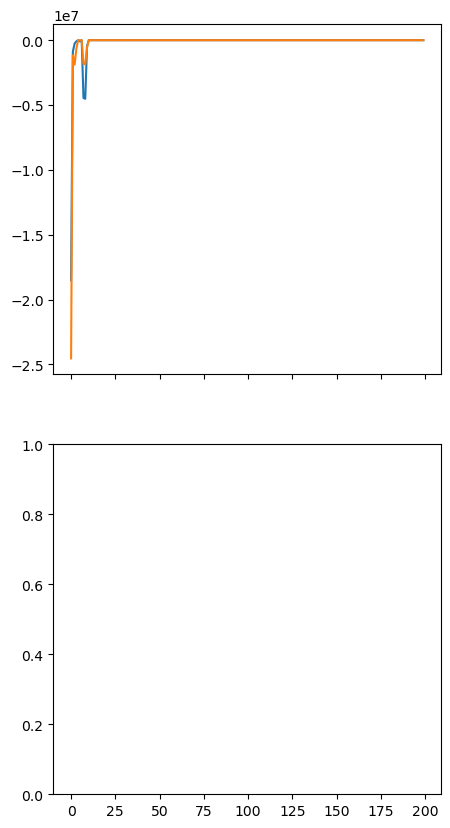

In [9]:
# show the transition from a "good" B to a "bad" B 
%matplotlib inline
fig, ax = plt.subplots(nrows=2, figsize=(5,10), sharex=True)
k = 0
i = 255


ax[0].plot(brs[k].pre_B_history[(i-1)-1])
ax[0].plot(brs[k].pre_B_history[(i)-1])
ax[0].set_title(f"{backends[k]} Pre_B's")
ax[0].set_ylim([0,10])

ax[1].plot(brs[k].B_history[i-1], label="t=254")
ax[1].plot(brs[k].B_history[i], label="t=255")
ax[1].set_title(f"{backends[k]} B's")
ax[1].legend();

In [ ]:
# check that the normalization or b_exp didn't cause the issue
%matplotlib inline
i=255
k = 0
B = np.array(brs[k].pre_B_history[i-1])
print(f"{np.argmax(B)}: {B.max()}")
B -= B.max()
B = np.exp(B)
plt.plot(B, label=backends[k])

B = np.array(brs[1-k].pre_B_history[i-1])
print(f"{np.argmax(B)}: {B.max()}")
B -= B.max()
B = np.exp(B)
plt.plot(B,label=backends[1-k])
plt.legend();

## logB

In [ ]:
def single_logB(x, mu, L, L_diag):
    n = mu.shape[0]
    B = (-1 / 2) * np.linalg.norm((x - mu) @ L) ** 2 - (n / 2) * np.log(2 * np.pi) + np.sum(L_diag)
    return B

In [ ]:
i = 255
B = [[], []]
for k in [0,1]:
    for m in range(200):
        L = brs[k].L_history[i-1][m]
        L_diag = brs[k].L_diag_history[i-1][m]
        mu = brs[k].mu_history[i-1][m]
        x = brs[k].input_ds.get_history()[0][i + 30]
        B[k].append(single_logB(x, mu, L, L_diag))
B = np.array(B)

In [ ]:
# show there isn't a problem in the logB calculations
k = 0
plt.plot(brs[k].pre_B_history[i-1])
plt.plot(B[k])
np.allclose(B[k], brs[k].pre_B_history[i-1])

## mu

In [ ]:
# show the on-bubble at i=254 has high probability
i = 254
k = 0
m = 4

L = brs[k].L_history[i-1][m]
L_diag = brs[k].L_diag_history[i-1][m]
mu = brs[k].mu_history[i-1][m]
x = brs[k].input_ds.get_history()[0][i + 30]

logB = single_logB(x, mu, L, L_diag)
assert np.allclose(brs[k].pre_B_history[i-1,m], logB)
logB

In [ ]:
# show the on-bubble at i=255 has low probability
i = 255
k = 0
m = 5

L = brs[k].L_history[i-1][m]
L_diag = brs[k].L_diag_history[i-1][m]
mu = brs[k].mu_history[i-1][m]
x = brs[k].input_ds.get_history()[0][i + 30]

logB = single_logB(x, mu, L, L_diag)
assert np.allclose(brs[k].pre_B_history[i-1,m], logB)
logB

In [ ]:
# show the on-bubble at i=255 should have had high probability
k = 0
m = 5

i = 254 # i==255 ⇔ bw_step==285
L = brs[k].L_history[i-1][m]
L_diag = brs[k].L_diag_history[i-1][m]
mu = brs[k].mu_history[i-1][m]


i = 255
x = brs[k].input_ds.get_history()[0][i + 30]

n = mu.shape[0]
logB = (-1 / 2) * np.linalg.norm((x - mu) @ L) ** 2 - (n / 2) * np.log(2 * np.pi) + np.sum(L_diag)
logB

In [ ]:
# show that it's mu's fault
k = 0
m = 5

i = 254 # i==255 ⇔ bw_step==285
mu = brs[k].mu_history[i-1][m]


i = 255
x = brs[k].input_ds.get_history()[0][i + 30]
L_diag = brs[k].L_diag_history[i-1][m]
L = brs[k].L_history[i-1][m]
# print(brs[k].mu_history[i-1][m] - mu)


n = mu.shape[0]
logB = (-1 / 2) * np.linalg.norm((x - mu) @ L) ** 2 - (n / 2) * np.log(2 * np.pi) + np.sum(L_diag)
logB

In [ ]:
brs[k].mu_history[255-1][m] - brs[k].mu_history[(255-1)-1][m]

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()

m = 5

k = 0
l = []
for i in range(450):    
    L = brs[k].L_history[i-1][m]
    L_diag = brs[k].L_diag_history[i-1][m]
    mu = brs[k].mu_history[i-1][m]
    
    i = i+1
    x = brs[k].obs_ds.get_history()[0][i + 30]
    
    l.append(single_logB(x, mu, L, L_diag))
ax.plot(l)

k = 1
l = []
for i in range(450):    
    L = brs[k].L_history[i-1][m]
    L_diag = brs[k].L_diag_history[i-1][m]
    mu = brs[k].mu_history[i-1][m]
    
    i = i+1
    x = brs[k].obs_ds.get_history()[0][i + 30]
    
    l.append(single_logB(x, mu, L, L_diag))
ax.plot(l)

ax.set_ylim([-2e4,2e3])

In [ ]:
k = 0
m = 5

%matplotlib inline
fig, ax = plt.subplots()
gpu_line = np.log(np.linalg.det(brs[k].L_history[:, m, ...]))
ax.plot(gpu_line, label='gpu')
cpu_line = np.log(np.linalg.det(brs[1-k].L_history[:, m, ...]))
ax.plot(cpu_line, label='cpu')
ax.set_title(f"log-determinant of L for bubble {m} per iteration");
ax.axvline(first_divergence_index, color='k', alpha=.25)
ax.legend();
print(gpu_line[first_divergence_index])

(460, 9.8)
(178, )

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
i = -300
m = 5

for k in [0,1]:
    L = brs[k].L_history[i,m,...]
    mu = brs[k].mu_history[i,m,:]
    al.plotting_functions.add_2d_bubble(ax, L, mu, 3, alpha=.5, facecolor=["red", 'blue'][k])

ax.set_xlim(mu[0] + np.array([-1,1])*.05)
ax.set_ylim(mu[1] + np.array([-1,1])*.05)
ax.axis('scaled');

In [ ]:
fig,ax = plt.subplots()
i=50

m = 5
for k in [0,1]:
    ratios = []
    for i in range(brs[k].L_history.shape[0]):
        L = brs[k].L_history[i,m,...]
        _, s, _= np.linalg.svd(np.linalg.pinv(L.T@L))
        ratios.append(s.max() / s.min())
    ratios = np.log(ratios)
    if backends[k] == 'gpu':
        print(ratios[first_divergence_index])
    ax.plot(ratios, label=backends[k])

ax.set_title("log aspect ratio");
ax.legend();
ax.axvline(first_divergence_index, color='k', alpha=.25);

In [ ]:
k = 0
m=1
plt.plot(np.log(np.abs(np.diff(brs[k].L_history[:, m, ...], axis=0))).reshape([-1,4]));

In [ ]:
k = 1
m=3
plt.plot(np.log(np.abs(np.diff(brs[k].L_diag_history[:, m, ...], axis=0))).reshape([brs[k].L_diag_history.shape[0]-1,-1]))

gpu


/tmp/ipykernel_23806/1361508101.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(Q));


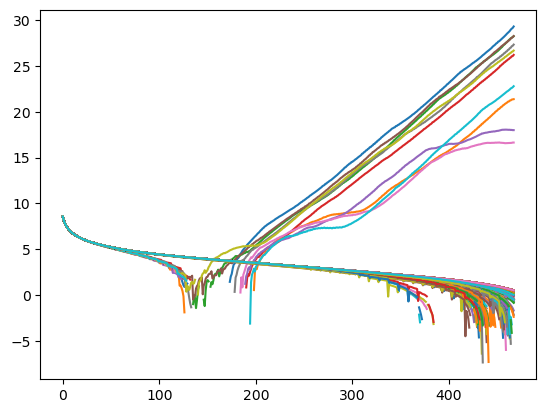

In [27]:
k = 0
print(brs[k].bw.backend_note)
Q = brs[k].model_step_variable_history['Q'];
plt.plot(np.log(Q));

In [20]:
Q.shape

(468, 200)